<a href="https://colab.research.google.com/github/gyiernahfufie/Classifying-COVID-X-Rays/blob/main/Classify%20COVID-19%20X-rays%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import copy, pickle, os, time

# This project uses COVID-19 Radiography Database that contains 4 different classes - COVID-19, Lung Opacity, Normal, and Viral Pneumonia.

Link to dataset: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

In [ ]:
#Setting root directory
root_dir = '/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset'
%cd /content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset

/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset


# Splitting into train, val, and test dataset.

In [ ]:
#import required libraries
import os
import shutil
import random

In [ ]:
#creates train, test, and val folders in directory and split dataset.
class_names = ['Normal', 'Viral Pneumonia', 'COVID','Lung_Opacity']
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID','Lung_Opacity']

os.mkdir(os.path.join(root_dir, 'train'))
os.mkdir(os.path.join(root_dir, 'test'))
os.mkdir(os.path.join(root_dir, 'val'))

for i, d in enumerate(source_dirs):
    os.renames(
        os.path.join(root_dir, d),
        os.path.join(root_dir, class_names[i])
    )

for c in class_names:
    os.mkdir(os.path.join(root_dir, 'test', c))
    os.mkdir(os.path.join(root_dir, 'val', c))

    images = [i for i in os.listdir(os.path.join(
        root_dir, c)) if i.lower().endswith('png')]
    test_images = random.sample(images, 60) #60 test images for each class
    images = list(set(images) - set(test_images))
    val_images = random.sample(images, 60) #60 validation images for each class

    for image in test_images:
        shutil.move(
            os.path.join(root_dir, c, image),
            os.path.join(root_dir, 'test', c, image)
        )

    for image in val_images:
        shutil.move(
            os.path.join(root_dir, c, image),
            os.path.join(root_dir, 'val', c, image)
        )

    shutil.move(
        os.path.join(root_dir, c),
        os.path.join(root_dir, 'train')
    )

# Image Augmentation
- resize to 224*224 per requirements of pre-trained models.
- horizontally flip given images randomly
- normalize using mean and std of Imagenet

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}

In [ ]:
dirs = {
    'train': '/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/train',
    'val': '/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/val',
    'test': '/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/test'
}

train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['val'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=2)
#num_workers =  how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.

## Data Exploration

In [ ]:
#number of classes in training dataset
train_set.classes 

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [ ]:
#updating class to index
train_set.class_to_idx #dictionary mapping the name of the class to the index

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
print(f'Number of Images in Train Set: {len(train_set)}')
print(f'Number of Images in Validation Set: {len(val_set)}')
print(f'Number of Images in Test Set: {len(test_set)}')

Number of Images in Train Set: 20565
Number of Images in Validation Set: 240
Number of Images in Test Set: 240


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

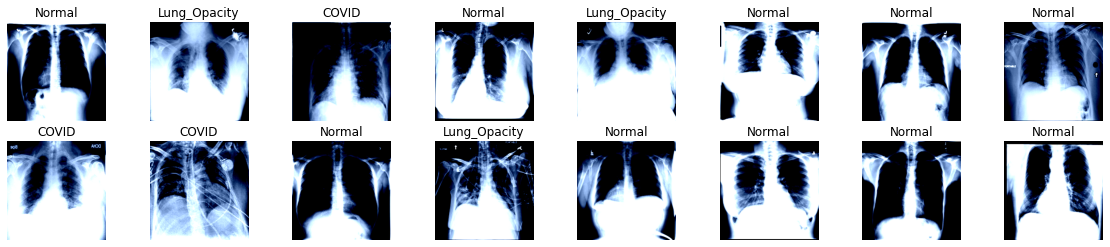

In [ ]:
#Plotting augmented images in training dataset.
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(20, 4))
for i in np.arange(16):
    ax = fig.add_subplot(2, 8, i+1)
    ax.axis('off')
    image = np.squeeze(np.transpose(images[i], (1, 2, 0)))
    ax.imshow(image)
    ax.set_title(train_set.classes[labels[i].item()])

plt.show()
fig.savefig('/content/gdrive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/samples.png', bbox_inches='tight')
plt.close()

In [ ]:
freq_train = torch.as_tensor(train_set.targets).bincount() #count each label frequency in the dataset
freq_val = torch.as_tensor(val_set.targets).bincount()
freq_test = torch.as_tensor(test_set.targets).bincount()
freq_all = freq_train + freq_test + freq_val

In [ ]:
def log_freq(dset, dfreq):
    for c, i in dset.class_to_idx.items():
        print(f'Number of {c.capitalize()} X-Rays: {dfreq[i].item()}')

A summary of number of images in each dataset.

In [ ]:
print('========== Train Set ==========')
log_freq(train_set, freq_train)
print('======== Validation Set ========')
log_freq(val_set, freq_val)
print('=========== Test Set ===========')
log_freq(test_set, freq_test)

========== Train Set ==========
Number of Covid X-Rays: 3466
Number of Lung_opacity X-Rays: 5862
Number of Normal X-Rays: 10042
Number of Viral pneumonia X-Rays: 1195
======== Validation Set ========
Number of Covid X-Rays: 60
Number of Lung_opacity X-Rays: 60
Number of Normal X-Rays: 60
Number of Viral pneumonia X-Rays: 60
=========== Test Set ===========
Number of Covid X-Rays: 60
Number of Lung_opacity X-Rays: 60
Number of Normal X-Rays: 60
Number of Viral pneumonia X-Rays: 60


Frequency plot based on classes in training dataset.

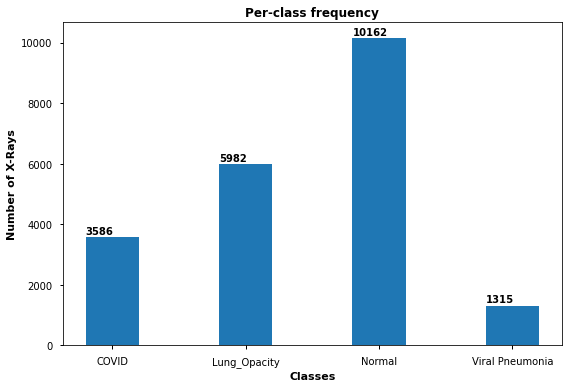

In [ ]:
plt.style.use('seaborn-notebook')

plt.bar(train_set.classes, freq_all.numpy(), width=0.4)

for i, v in enumerate(freq_all.numpy()):
    plt.text(i-.2, v+100, str(v), fontweight='bold')

plt.xlabel('Classes', fontweight='bold')
plt.ylabel('Number of X-Rays', fontweight='bold')
plt.title('Per-class frequency', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/class_freq.png')

plt.show()
plt.close()

Based on the plot above, it can be observed that class imbalanced exist in the dataset.

#Modelling Preparation

In [ ]:
import csv
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Defining functions for model implementation.

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
#eq: Computes element-wise equality
#argmax: Returns the indices of the maximum value of all elements in the input tensor.

def get_all_preds(model, loader):
    model.eval()
    with torch.no_grad():
        all_preds = torch.tensor([], device=device)
        for batch in loader:
            images = batch[0].to(device)
            preds = model(images)
            all_preds = torch.cat((all_preds, preds), dim=0)

    return all_preds


def get_confmat(targets, preds):
    stacked = torch.stack(
        (torch.as_tensor(targets, device=device),
         preds.argmax(dim=1)), dim=1
    ).tolist()
    confmat = torch.zeros(4, 4, dtype=torch.int16)
    for t, p in stacked:
        confmat[t, p] += 1

    return confmat

#torch.stack: Concatenates a sequence of tensors along a new dimension.
#torch.zeros: Returns a tensor filled with the scalar value 0, with the shape defined by the variable argument size.

def get_results(confmat, classes):
    results = {}
    d = confmat.diagonal()
    for i, l in enumerate(classes):
        tp = d[i].item()
        tn = d.sum().item() - tp
        fp = confmat[i].sum().item() - tp
        fn = confmat[:, i].sum().item() - tp
        
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        f1score = (2*precision*recall)/(precision+recall)
       

        results[l] = [accuracy, recall, precision, f1score]

    return results

#trains model and evaluate every epoch
def fit(epochs, model, criterion, optimizer,scheduler, train_dl, valid_dl):
    model_name = type(model).__name__.lower()
    valid_loss_min = np.Inf
    len_train, len_valid = 20565, 240
    fields = [
        'epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'
    ]
    rows = []

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0
        train_loop = tqdm(train_dl) #fetching data from dataloader

#tqdm: progress bar for Python

        model.train() #setting model to training mode
        
        #iterate over data
        for batch in train_loop:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad() #zero the parameter gradients
            loss.backward()
            optimizer.step() #performs updates using calculated loss
        
            scheduler.step() #when using lr scheduler #update learning rate

            train_loss += loss.item() * labels.size(0)
            train_correct += get_num_correct(preds, labels)

            train_loop.set_description(f'Epoch [{epoch+1:2d}/{epochs}]')
            train_loop.set_postfix(
                loss=loss.item(), acc=train_correct/len_train
            )
        
        #computing training loss and accuracy
        train_loss = train_loss/len_train
        train_acc = train_correct/len_train

        print('Epoch:', epoch,'LR:',scheduler.get_last_lr()) #when using lr scheduler 

        model.eval() #setting model to evaluate model
        with torch.no_grad(): #disabled gradient claculation 
            valid_loss, valid_correct = 0, 0
            for batch in valid_dl:
                images, labels = batch[0].to(device), batch[1].to(device)
                preds = model(images)
                loss = criterion(preds, labels)
                valid_loss += loss.item() * labels.size(0)
                valid_correct += get_num_correct(preds, labels)

            #computing validation loss and accuracy
            valid_loss = valid_loss/len_valid
            valid_acc = valid_correct/len_valid

            rows.append([epoch, train_loss, train_acc, valid_loss, valid_acc])

            train_loop.write(
                f'\n\t\tAvg train loss: {train_loss:.6f}', end='\t'
            )
            train_loop.write(f'Avg valid loss: {valid_loss:.6f}\n')

            # save model every time validation loss has decreased
            
            if valid_loss <= valid_loss_min:
                train_loop.write('\t\tvalid_loss decreased', end=' ')
                train_loop.write(f'({valid_loss_min:.6f} -> {valid_loss:.6f})')
                train_loop.write('\t\tsaving model...\n')
                torch.save(
                    model.state_dict(),
                    f'/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/misra_{model_name}_{device}_{epoch}.pth'
                )
                valid_loss_min = valid_loss

    # write running results for plots
    with open(f'/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/misra_{model_name}.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(fields)
        csv_writer.writerows(rows)


# worker init function for randomness in multiprocess dataloading
# https://github.com/pytorch/pytorch/issues/5059#issuecomment-817392562
def wif(id):
    process_seed = torch.initial_seed()
    base_seed = process_seed - id
    ss = np.random.SeedSequence([id, base_seed])
    # More than 128 bits (4 32-bit words) would be overkill.
    np.random.seed(ss.generate_state(4))


def load_image(path):
    image = Image.open(path)
    image = transform['eval'](image).unsqueeze(0)
    return image

#unsqueeze: Returns a new tensor with a dimension of size one inserted at the specified position.

#unormalize images
def deprocess_image(image):
    image = image.cpu().numpy()
    image = np.squeeze(np.transpose(image[0], (1, 2, 0)))
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))  # un-normalize
    image = image.clip(0, 1)
    return image


def save_image(image, path):
    # while saving PIL assumes the image is in BGR, and saves it as RGB.
    # But here the image is in RGB, therefore it is converted to BGR first.
    image = image[:, :, ::-1]  # RGB -> BGR
    image = Image.fromarray(image)
    image.save(path)  # saved as RGB
    print(f'GradCAM masked image saved to "{path}".')

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['val'])

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler

In [ ]:
# Weighted Random Sampling for dealing with imbalanced dataset
#Gives all classes with equal probability.
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq #creating class weight for each class
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

train_dl = DataLoader(train_set, batch_size=20, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=20)

# Transfer learning using pre-trained models



This steps involves reshaping final layer of all pre-trained models to have the same number of outputs as the number of classes (4) in the new dataset. The input size of each pre-trained model is set based on the input size of its last layer. These pre-trained models were originally trained on ImageNet. The reason for applying transfer learning using pre-trained models is due to the small dataset in COVID-19 classes. All models will be trained for 25 epochs, Adam optimizer for loss function with learning rate of 0.0001. Although each model will be trained for 25 epochs, model fit function was defined with an early stopping-like feature, that saves the model whenever validation loss decrases as compared to the previous epochs. This prevents overfitting and underfitting of the model. 

In [ ]:
epochs = 25
criterion = nn.CrossEntropyLoss() #categorical cross-entorpy loss for multi-class clssification 

# Densenet121

size of input = 1024
size of output = 4

In [ ]:
def get_densenet121(pretrained=False, out_features=None, path=None):
    model = torchvision.models.densenet121(pretrained=pretrained)
    if out_features is not None:
        model.classifier = torch.nn.Linear(
            in_features=1024, out_features=out_features
        )
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

In [ ]:
densenet121 = get_densenet121(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Densenet121 Architecture

In [ ]:
from torchsummary import summary

In [ ]:
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
fit(
    epochs=epochs,
    model=densenet121,
    criterion=criterion,
    optimizer=optim.Adam(densenet121.parameters(), lr=0.0001),
    train_dl=train_dl,
    valid_dl=valid_dl,
)

  0%|          | 0/1029 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.217902	Avg valid loss: 0.153447

		valid_loss decreased (inf -> 0.153447)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.121061	Avg valid loss: 0.147733

		valid_loss decreased (0.153447 -> 0.147733)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.095706	Avg valid loss: 0.080613

		valid_loss decreased (0.147733 -> 0.080613)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.086784	Avg valid loss: 0.104268



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.068539	Avg valid loss: 0.221450



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.069666	Avg valid loss: 0.064216

		valid_loss decreased (0.080613 -> 0.064216)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.057068	Avg valid loss: 0.092931



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.054507	Avg valid loss: 0.067625



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.046366	Avg valid loss: 0.107317



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.043706	Avg valid loss: 0.127773



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.038578	Avg valid loss: 0.171014



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.039074	Avg valid loss: 0.081017



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.036563	Avg valid loss: 0.081159



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.033849	Avg valid loss: 0.101425



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.027965	Avg valid loss: 0.086456



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.033003	Avg valid loss: 0.085889



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.024773	Avg valid loss: 0.143600



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.031150	Avg valid loss: 0.083941



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.024351	Avg valid loss: 0.107709



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.022334	Avg valid loss: 0.097596



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.024622	Avg valid loss: 0.133007



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.018540	Avg valid loss: 0.099701



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.019532	Avg valid loss: 0.130344



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.018746	Avg valid loss: 0.114681



Epoch [25/25]: 100%|██████████| 1029/1029 [04:26<00:00,  3.86it/s, acc=0.994, loss=0.345]



		Avg train loss: 0.019030	Avg valid loss: 0.106801



In [ ]:
#Fine-tuning using lr scheduler
optimizer=optim.Adam(densenet121.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3147, gamma=0.1)

In [ ]:
fit(
    epochs,
    densenet121,
    criterion,
    optimizer,
    exp_lr_scheduler,
    train_dl,
    valid_dl,
)

  0%|          | 0/1029 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch [ 1/25]: 100%|██████████| 1029/1029 [32:15<00:00,  1.88s/it, acc=0.925, loss=0.48]


Epoch: 0 LR: [0.0001]

		Avg train loss: 0.214563	Avg valid loss: 0.161096

		valid_loss decreased (inf -> 0.161096)
		saving model...



Epoch [ 2/25]: 100%|██████████| 1029/1029 [13:36<00:00,  1.26it/s, acc=0.96, loss=0.349]


Epoch: 1 LR: [0.0001]

		Avg train loss: 0.115838	Avg valid loss: 0.163102



Epoch [ 3/25]: 100%|██████████| 1029/1029 [07:21<00:00,  2.33it/s, acc=0.967, loss=0.0348]


Epoch: 2 LR: [0.0001]

		Avg train loss: 0.099098	Avg valid loss: 0.092256

		valid_loss decreased (0.161096 -> 0.092256)
		saving model...



Epoch [ 4/25]: 100%|██████████| 1029/1029 [05:17<00:00,  3.24it/s, acc=0.978, loss=0.084]


Epoch: 3 LR: [1e-05]

		Avg train loss: 0.062463	Avg valid loss: 0.070466

		valid_loss decreased (0.092256 -> 0.070466)
		saving model...



Epoch [ 5/25]: 100%|██████████| 1029/1029 [04:37<00:00,  3.71it/s, acc=0.985, loss=0.031]


Epoch: 4 LR: [1e-05]

		Avg train loss: 0.046580	Avg valid loss: 0.073585



Epoch [ 6/25]: 100%|██████████| 1029/1029 [04:29<00:00,  3.82it/s, acc=0.987, loss=0.00131]


Epoch: 5 LR: [1e-05]

		Avg train loss: 0.044033	Avg valid loss: 0.069366

		valid_loss decreased (0.070466 -> 0.069366)
		saving model...



Epoch [ 7/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.988, loss=0.00287]


Epoch: 6 LR: [1.0000000000000002e-06]

		Avg train loss: 0.038479	Avg valid loss: 0.068609

		valid_loss decreased (0.069366 -> 0.068609)
		saving model...



Epoch [ 8/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.87it/s, acc=0.988, loss=0.031]


Epoch: 7 LR: [1.0000000000000002e-06]

		Avg train loss: 0.039046	Avg valid loss: 0.069417



Epoch [ 9/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.87it/s, acc=0.987, loss=0.0282]


Epoch: 8 LR: [1.0000000000000002e-06]

		Avg train loss: 0.039228	Avg valid loss: 0.067062

		valid_loss decreased (0.068609 -> 0.067062)
		saving model...



Epoch [10/25]: 100%|██████████| 1029/1029 [04:24<00:00,  3.89it/s, acc=0.988, loss=0.0486]


Epoch: 9 LR: [1.0000000000000002e-07]

		Avg train loss: 0.035979	Avg valid loss: 0.066996

		valid_loss decreased (0.067062 -> 0.066996)
		saving model...



Epoch [11/25]: 100%|██████████| 1029/1029 [04:24<00:00,  3.89it/s, acc=0.989, loss=1.31]


Epoch: 10 LR: [1.0000000000000002e-07]

		Avg train loss: 0.034447	Avg valid loss: 0.069907



Epoch [12/25]: 100%|██████████| 1029/1029 [04:24<00:00,  3.89it/s, acc=0.989, loss=0.101]


Epoch: 11 LR: [1.0000000000000002e-07]

		Avg train loss: 0.034767	Avg valid loss: 0.067150



Epoch [13/25]: 100%|██████████| 1029/1029 [04:24<00:00,  3.89it/s, acc=0.99, loss=0.0328]


Epoch: 12 LR: [1.0000000000000004e-08]

		Avg train loss: 0.032074	Avg valid loss: 0.065519

		valid_loss decreased (0.066996 -> 0.065519)
		saving model...



Epoch [14/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.991, loss=0.00784]


Epoch: 13 LR: [1.0000000000000004e-08]

		Avg train loss: 0.032363	Avg valid loss: 0.068003



Epoch [15/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.87it/s, acc=0.988, loss=0.0107]


Epoch: 14 LR: [1.0000000000000004e-08]

		Avg train loss: 0.036605	Avg valid loss: 0.067035



Epoch [16/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.989, loss=0.00604]


Epoch: 15 LR: [1.0000000000000005e-09]

		Avg train loss: 0.035477	Avg valid loss: 0.067435



Epoch [17/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.989, loss=0.753]


Epoch: 16 LR: [1.0000000000000005e-09]

		Avg train loss: 0.034647	Avg valid loss: 0.073010



Epoch [18/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.989, loss=0.00369]


Epoch: 17 LR: [1.0000000000000005e-09]

		Avg train loss: 0.036411	Avg valid loss: 0.071208



Epoch [19/25]: 100%|██████████| 1029/1029 [04:24<00:00,  3.88it/s, acc=0.988, loss=0.00644]


Epoch: 18 LR: [1.0000000000000006e-10]

		Avg train loss: 0.036685	Avg valid loss: 0.068124



Epoch [20/25]: 100%|██████████| 1029/1029 [04:26<00:00,  3.86it/s, acc=0.99, loss=4.88]


Epoch: 19 LR: [1.0000000000000006e-10]

		Avg train loss: 0.033938	Avg valid loss: 0.070712



Epoch [21/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.989, loss=0.00597]


Epoch: 20 LR: [1.0000000000000006e-10]

		Avg train loss: 0.035040	Avg valid loss: 0.066953



Epoch [22/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.989, loss=0.00325]


Epoch: 21 LR: [1.0000000000000006e-11]

		Avg train loss: 0.033312	Avg valid loss: 0.069461



Epoch [23/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.988, loss=0.00899]


Epoch: 22 LR: [1.0000000000000006e-11]

		Avg train loss: 0.037654	Avg valid loss: 0.066784



Epoch [24/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.989, loss=0.0562]


Epoch: 23 LR: [1.0000000000000006e-11]

		Avg train loss: 0.033800	Avg valid loss: 0.066704



Epoch [25/25]: 100%|██████████| 1029/1029 [04:25<00:00,  3.88it/s, acc=0.989, loss=1.1]


Epoch: 24 LR: [1.0000000000000006e-12]

		Avg train loss: 0.033502	Avg valid loss: 0.069133



# Resnet18

size of input = 512
size of output = 4

In [ ]:
def get_resnet18(pretrained=False, out_features=None, path=None):
    model = torchvision.models.resnet18(pretrained=pretrained)
    if out_features is not None:
        model.fc = torch.nn.Linear(in_features=512, out_features=out_features)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

In [ ]:
resnet18 = get_resnet18(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Resnet18 Architecture

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
fit(
    epochs=epochs,
    model=resnet18,
    criterion=criterion,
    optimizer=optim.Adam(resnet18.parameters(), lr=0.0001),
    train_dl=train_dl,
    valid_dl=valid_dl
)

  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.214268	Avg valid loss: 0.144212

		valid_loss decreased (inf -> 0.144212)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.116723	Avg valid loss: 0.113534

		valid_loss decreased (0.144212 -> 0.113534)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.099127	Avg valid loss: 0.147739



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.090319	Avg valid loss: 0.111743

		valid_loss decreased (0.113534 -> 0.111743)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.075277	Avg valid loss: 0.069880

		valid_loss decreased (0.111743 -> 0.069880)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.073965	Avg valid loss: 0.064792

		valid_loss decreased (0.069880 -> 0.064792)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.059975	Avg valid loss: 0.093321



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.057664	Avg valid loss: 0.118357



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.050318	Avg valid loss: 0.137526



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.045835	Avg valid loss: 0.076851



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.043115	Avg valid loss: 0.079423



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.035399	Avg valid loss: 0.088031



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.041689	Avg valid loss: 0.098341



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.027770	Avg valid loss: 0.079528



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.034178	Avg valid loss: 0.112717



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.028155	Avg valid loss: 0.128433



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.026423	Avg valid loss: 0.106056



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.025595	Avg valid loss: 0.094222



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.025805	Avg valid loss: 0.094506



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.022201	Avg valid loss: 0.113010



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.020317	Avg valid loss: 0.097555



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.019062	Avg valid loss: 0.128071



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.018645	Avg valid loss: 0.126514



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.016872	Avg valid loss: 0.111983



Epoch [25/25]: 100%|██████████| 1029/1029 [01:53<00:00,  9.04it/s, acc=0.994, loss=0.000676]



		Avg train loss: 0.017061	Avg valid loss: 0.110006



In [ ]:
#Fine-tuning using lr scheduler
optimizer=optim.Adam(resnet18.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3147, gamma=0.1)

In [ ]:
fit(
    epochs,
    resnet18,
    criterion,
    optimizer,
    exp_lr_scheduler,
    train_dl,
    valid_dl,
)

Epoch [ 1/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.43it/s, acc=0.919, loss=0.0748]


Epoch: 0 LR: [0.0001]

		Avg train loss: 0.218201	Avg valid loss: 0.158590

		valid_loss decreased (inf -> 0.158590)
		saving model...



Epoch [ 2/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.42it/s, acc=0.956, loss=0.241]


Epoch: 1 LR: [0.0001]

		Avg train loss: 0.127119	Avg valid loss: 0.104284

		valid_loss decreased (0.158590 -> 0.104284)
		saving model...



Epoch [ 3/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.39it/s, acc=0.962, loss=0.217]


Epoch: 2 LR: [0.0001]

		Avg train loss: 0.105059	Avg valid loss: 0.092008

		valid_loss decreased (0.104284 -> 0.092008)
		saving model...



Epoch [ 4/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.39it/s, acc=0.975, loss=0.036]


Epoch: 3 LR: [1e-05]

		Avg train loss: 0.071964	Avg valid loss: 0.081943

		valid_loss decreased (0.092008 -> 0.081943)
		saving model...



Epoch [ 5/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.37it/s, acc=0.982, loss=0.00945]


Epoch: 4 LR: [1e-05]

		Avg train loss: 0.053782	Avg valid loss: 0.082376



Epoch [ 6/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.33it/s, acc=0.985, loss=0.0134]


Epoch: 5 LR: [1e-05]

		Avg train loss: 0.045970	Avg valid loss: 0.078123

		valid_loss decreased (0.081943 -> 0.078123)
		saving model...



Epoch [ 7/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.37it/s, acc=0.985, loss=0.286]


Epoch: 6 LR: [1.0000000000000002e-06]

		Avg train loss: 0.043241	Avg valid loss: 0.084970



Epoch [ 8/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.35it/s, acc=0.986, loss=0.00111]


Epoch: 7 LR: [1.0000000000000002e-06]

		Avg train loss: 0.041450	Avg valid loss: 0.080668



Epoch [ 9/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.30it/s, acc=0.986, loss=0.000869]


Epoch: 8 LR: [1.0000000000000002e-06]

		Avg train loss: 0.040878	Avg valid loss: 0.082982



Epoch [10/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.36it/s, acc=0.986, loss=0.701]


Epoch: 9 LR: [1.0000000000000002e-07]

		Avg train loss: 0.040802	Avg valid loss: 0.080924



Epoch [11/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.30it/s, acc=0.986, loss=0.0375]


Epoch: 10 LR: [1.0000000000000002e-07]

		Avg train loss: 0.041563	Avg valid loss: 0.078449



Epoch [12/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.32it/s, acc=0.986, loss=0.00202]


Epoch: 11 LR: [1.0000000000000002e-07]

		Avg train loss: 0.043660	Avg valid loss: 0.075660

		valid_loss decreased (0.078123 -> 0.075660)
		saving model...



Epoch [13/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.32it/s, acc=0.986, loss=0.0202]


Epoch: 12 LR: [1.0000000000000004e-08]

		Avg train loss: 0.040563	Avg valid loss: 0.073992

		valid_loss decreased (0.075660 -> 0.073992)
		saving model...



Epoch [14/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.37it/s, acc=0.987, loss=0.273]


Epoch: 13 LR: [1.0000000000000004e-08]

		Avg train loss: 0.040235	Avg valid loss: 0.078650



Epoch [15/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.33it/s, acc=0.986, loss=0.0133]


Epoch: 14 LR: [1.0000000000000004e-08]

		Avg train loss: 0.041639	Avg valid loss: 0.078277



Epoch [16/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.34it/s, acc=0.988, loss=0.0114]


Epoch: 15 LR: [1.0000000000000005e-09]

		Avg train loss: 0.037838	Avg valid loss: 0.075484



Epoch [17/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.35it/s, acc=0.988, loss=0.0889]


Epoch: 16 LR: [1.0000000000000005e-09]

		Avg train loss: 0.038759	Avg valid loss: 0.079974



Epoch [18/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.33it/s, acc=0.987, loss=0.249]


Epoch: 17 LR: [1.0000000000000005e-09]

		Avg train loss: 0.040727	Avg valid loss: 0.078417



Epoch [19/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.35it/s, acc=0.985, loss=0.0112]


Epoch: 18 LR: [1.0000000000000006e-10]

		Avg train loss: 0.045211	Avg valid loss: 0.069836

		valid_loss decreased (0.073992 -> 0.069836)
		saving model...



Epoch [20/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.36it/s, acc=0.987, loss=0.000277]


Epoch: 19 LR: [1.0000000000000006e-10]

		Avg train loss: 0.040783	Avg valid loss: 0.074516



Epoch [21/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.34it/s, acc=0.987, loss=0.0309]


Epoch: 20 LR: [1.0000000000000006e-10]

		Avg train loss: 0.041039	Avg valid loss: 0.084237



Epoch [22/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.34it/s, acc=0.987, loss=0.00105]


Epoch: 21 LR: [1.0000000000000006e-11]

		Avg train loss: 0.039223	Avg valid loss: 0.074930



Epoch [23/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.37it/s, acc=0.987, loss=0.00306]


Epoch: 22 LR: [1.0000000000000006e-11]

		Avg train loss: 0.038995	Avg valid loss: 0.072522



Epoch [24/25]: 100%|██████████| 1029/1029 [01:50<00:00,  9.35it/s, acc=0.985, loss=0.0527]


Epoch: 23 LR: [1.0000000000000006e-11]

		Avg train loss: 0.043261	Avg valid loss: 0.076217



Epoch [25/25]: 100%|██████████| 1029/1029 [01:49<00:00,  9.36it/s, acc=0.987, loss=0.0303]


Epoch: 24 LR: [1.0000000000000006e-12]

		Avg train loss: 0.039677	Avg valid loss: 0.080390



# Squeezenet

size of input = 512
size of output = 4


In [ ]:
def get_squeezenet(pretrained=False, out_features=None, path=None):
    model = torchvision.models.squeezenet1_1(pretrained=pretrained)
    if out_features is not None:
        model.classifier[1] = torch.nn.Conv2d(
            512, 4, kernel_size=(1, 1), stride=(1, 1)
        )
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

In [ ]:
squeezenet = get_squeezenet(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Squeezenet Architecture

In [ ]:
squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
fit(
    epochs=epochs,
    model=squeezenet,
    criterion=criterion,
    optimizer=optim.Adam(squeezenet.parameters(), lr=0.0001),
    train_dl=train_dl,
    valid_dl=valid_dl
)

  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.399450	Avg valid loss: 0.334250

		valid_loss decreased (inf -> 0.334250)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.234499	Avg valid loss: 0.239445

		valid_loss decreased (0.334250 -> 0.239445)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.182870	Avg valid loss: 0.261744



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.172431	Avg valid loss: 0.196770

		valid_loss decreased (0.239445 -> 0.196770)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.147972	Avg valid loss: 0.159971

		valid_loss decreased (0.196770 -> 0.159971)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.138363	Avg valid loss: 0.188301



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.139441	Avg valid loss: 0.176762



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.130907	Avg valid loss: 0.139731

		valid_loss decreased (0.159971 -> 0.139731)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.119515	Avg valid loss: 0.213780



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.121752	Avg valid loss: 0.184172



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.109738	Avg valid loss: 0.135093

		valid_loss decreased (0.139731 -> 0.135093)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.104075	Avg valid loss: 0.189751



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.101077	Avg valid loss: 0.134563

		valid_loss decreased (0.135093 -> 0.134563)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.094923	Avg valid loss: 0.152164



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.089573	Avg valid loss: 0.132963

		valid_loss decreased (0.134563 -> 0.132963)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.084387	Avg valid loss: 0.143277



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.081854	Avg valid loss: 0.119957

		valid_loss decreased (0.132963 -> 0.119957)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.084097	Avg valid loss: 0.143144



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.082121	Avg valid loss: 0.126036



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.080197	Avg valid loss: 0.204502



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.075880	Avg valid loss: 0.132514



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.068036	Avg valid loss: 0.169283



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.070032	Avg valid loss: 0.169454



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.068041	Avg valid loss: 0.117238

		valid_loss decreased (0.119957 -> 0.117238)
		saving model...



Epoch [25/25]: 100%|██████████| 1029/1029 [01:47<00:00,  9.59it/s, acc=0.974, loss=4.55e-6]



		Avg train loss: 0.066921	Avg valid loss: 0.126363



# Resnet50

size of input = 2048
size of output = 4


In [ ]:
def get_resnet50(pretrained=False, out_features=None, path=None):
    model = torchvision.models.resnet50(pretrained=pretrained)
    if out_features is not None:
        model.fc = torch.nn.Linear(in_features=2048, out_features=out_features)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)

In [ ]:
resnet50 = get_resnet50(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Resnet50 Architecture

In [ ]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
fit(
    epochs=epochs,
    model=resnet50,
    criterion=criterion,
    optimizer=optim.Adam(resnet50.parameters(), lr=0.0001),
    train_dl=train_dl,
    valid_dl=valid_dl
)

Epoch [ 1/25]: 100%|██████████| 1029/1029 [04:00<00:00,  4.28it/s, acc=0.923, loss=1.57]



		Avg train loss: 0.216740	Avg valid loss: 0.127963

		valid_loss decreased (inf -> 0.127963)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.139645	Avg valid loss: 0.128659



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.108055	Avg valid loss: 0.286367



Epoch [ 4/25]: 100%|██████████| 1029/1029 [04:00<00:00,  4.29it/s, acc=0.967, loss=0.0175]



		Avg train loss: 0.094632	Avg valid loss: 0.106775

		valid_loss decreased (0.127963 -> 0.106775)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.086118	Avg valid loss: 0.126300



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.081290	Avg valid loss: 0.422114



Epoch [ 7/25]: 100%|██████████| 1029/1029 [04:00<00:00,  4.28it/s, acc=0.977, loss=0.154]



		Avg train loss: 0.066109	Avg valid loss: 0.092978

		valid_loss decreased (0.106775 -> 0.092978)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.059629	Avg valid loss: 0.179910



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.063358	Avg valid loss: 0.117086



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.051760	Avg valid loss: 0.109184



Epoch [11/25]: 100%|██████████| 1029/1029 [04:01<00:00,  4.26it/s, acc=0.983, loss=8.65e-5]



		Avg train loss: 0.048894	Avg valid loss: 0.078578

		valid_loss decreased (0.092978 -> 0.078578)
		saving model...



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.041475	Avg valid loss: 0.101189



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.041105	Avg valid loss: 0.101044



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.035874	Avg valid loss: 0.106312



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.035201	Avg valid loss: 0.116461



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.033611	Avg valid loss: 0.103126



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.027033	Avg valid loss: 0.154898



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.028312	Avg valid loss: 0.116602



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.025539	Avg valid loss: 0.127772



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.025857	Avg valid loss: 0.140213



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.026843	Avg valid loss: 0.107651



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.029126	Avg valid loss: 0.101687



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.018273	Avg valid loss: 0.110839



  0%|          | 0/1029 [00:00<?, ?it/s]


		Avg train loss: 0.022276	Avg valid loss: 0.176783



Epoch [25/25]: 100%|██████████| 1029/1029 [04:00<00:00,  4.27it/s, acc=0.993, loss=0.011]



		Avg train loss: 0.020094	Avg valid loss: 0.128041



# Plotting running losses & accuracies. 

In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#for plotting accuracy and loss line chart
def plot_summary(path):
    data = pd.read_csv(path)
    filename = path.split('/')[-1][:-4]

    plt.style.use('seaborn-whitegrid')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    ax1.plot(data['epoch'], data['train_loss'], label='Train Loss')
    ax1.plot(data['epoch'], data['valid_loss'], label='Valid Loss')
    ax1.axhline(data['valid_loss'].min(),
                linestyle=(0, (5, 10)), linewidth=0.5)
    ax1.axvline(data['valid_loss'].idxmin(),
                linestyle=(0, (5, 10)), linewidth=0.5)
    ax1.text(11, data['valid_loss'].min(), 'min valid loss',
             backgroundcolor='white', va='center', size=7.5)

    ax2.plot(data['epoch'], data['train_acc'], label='Train Accuracy')
    ax2.plot(data['epoch'], data['valid_acc'], label='Valid Accuracy')

    ax1.legend()
    ax1.set_title('Running Loss', fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.legend()
    ax2.set_title('Running Accuracy', fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    fig.savefig(f'/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/{filename}.png')
    plt.show()
    plt.close()

#function to plot confusion matrix
def plot_confmat(train_mat, test_mat, classes, filename):
    train_mat = pd.DataFrame(train_mat.numpy(), index=classes, columns=classes)
    test_mat = pd.DataFrame(test_mat.numpy(), index=classes, columns=classes)

    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(16, 6))

    ax = fig.add_subplot(121)
    ax = sns.heatmap(train_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Train Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    ax = fig.add_subplot(122)
    ax = sns.heatmap(test_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Test Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    plt.tight_layout()
    fig.savefig(f'/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/{filename}')
    plt.show()
    plt.close()


def apply_mask(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def plot_gradcam(image, res50_cam, res18_cam, dense_cam,squeeze_cam):
    image = deprocess_image(image)
    name_dict = {
        'Original Image': image,
        'GradCAM (ResNet-50)': apply_mask(image, res50_cam),
        'GradCAM (ResNet-18)': apply_mask(image, res18_cam),
        'GradCAM (DenseNet-121)': apply_mask(image, dense_cam),
        'GradCAM (Squeezenet 1_1)': apply_mask(image, squeeze_cam),
    }

    plt.style.use('seaborn-notebook')
    fig = plt.figure(figsize=(20, 4))
    for i, (name, img) in enumerate(name_dict.items()):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        if i:
            img = img[:, :, ::-1]
        ax.imshow(img)
        ax.set_xlabel(name, fontweight='bold')

    fig.suptitle(
        'Localization with Gradient based Class Activation Maps',
        fontweight='bold', fontsize=16
    )
    plt.tight_layout()
    fig.savefig('/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/grad_cam.png')
    plt.show()
    plt.close()

# Densenet121 plot

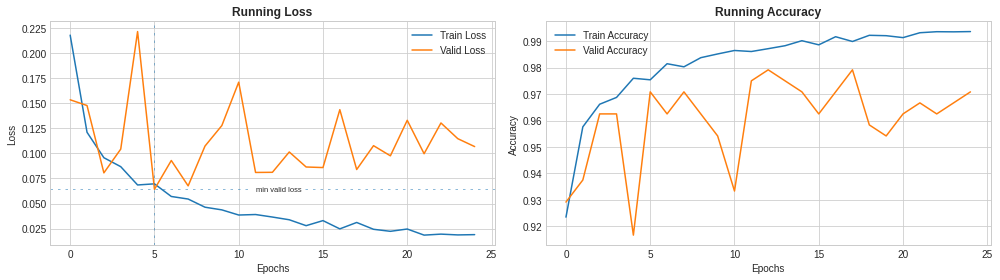

In [ ]:
plot_summary('/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Densenet121/misra_densenet.csv')

The validation loss is the lowest at epoch 6 at 0.064216. As number of epoch increases we see that the model is starting to be overfitting with an increased of validation loss.

# Densenet121 with learning rate scheduler plot

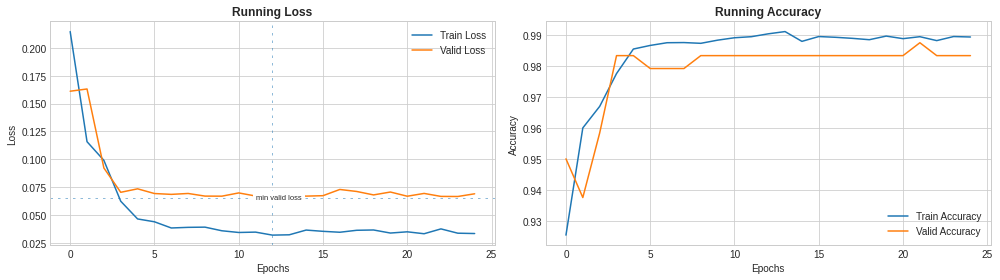

In [ ]:
plot_summary('/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/densenet_lr scheduler_3147_0.1/misra_densenet.csv')

The validation loss is the lowest at epoch 13 at 0.065519. 

# Resnet18 plot

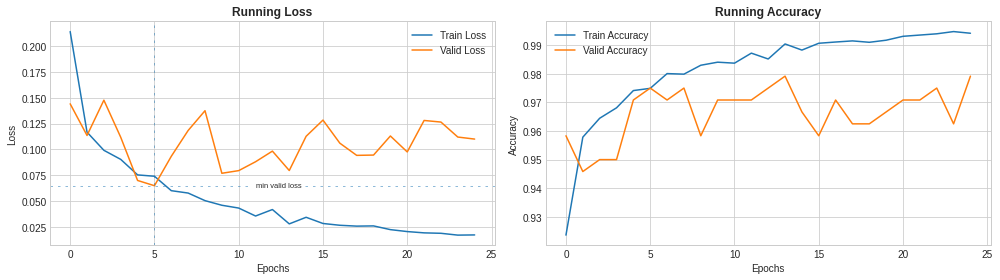

In [ ]:
plot_summary('/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Resnet18/misra_resnet.csv')

The validation loss is the lowest at epoch 6 at 0.064792.

# Resnet18 with learning rate scheduler plot

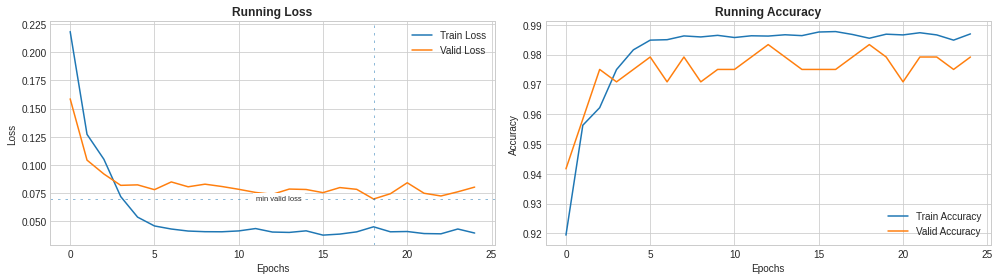

In [ ]:
plot_summary('/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/resnet18_lr scheduler_3147_0.1/misra_resnet.csv')

The validation loss is the lowest at epoch 19 with validation loss of 0.069836

# Squeezenet plot


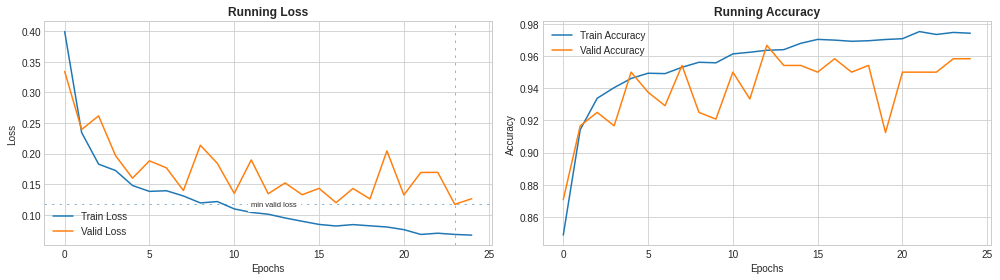

In [ ]:
plot_summary('/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Squeezenet1_1/misra_squeezenet.csv')

The validation loss is the lowest at epoch 24 at 0.117238

# Resnet50 plot

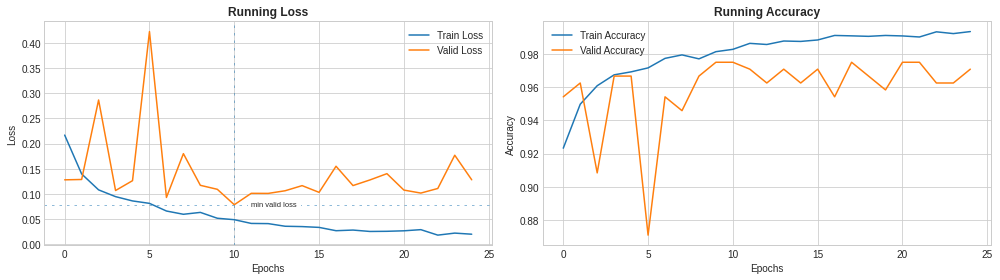

In [ ]:
plot_summary('/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Resnet50/misra_resnet.csv')

The validation loss is the lowest at epoch 11 at 0.078578.

# Results evaluation

Predicting test dataset using model with lowest validation loss.

In [ ]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['val'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['val'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

**Resnet18**

In [ ]:
resnet18 = get_resnet18(out_features=4, path='/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Resnet18/misra_resnet_cuda_5.pth')
train_preds = get_all_preds(resnet18, train_dl)
test_preds = get_all_preds(resnet18, test_dl)

train_preds.shape, test_preds.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(torch.Size([20565, 4]), torch.Size([240, 4]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 20105	Train Accuracy: 97.76%
Test Correct:    231	Test Accuracy:  96.25%


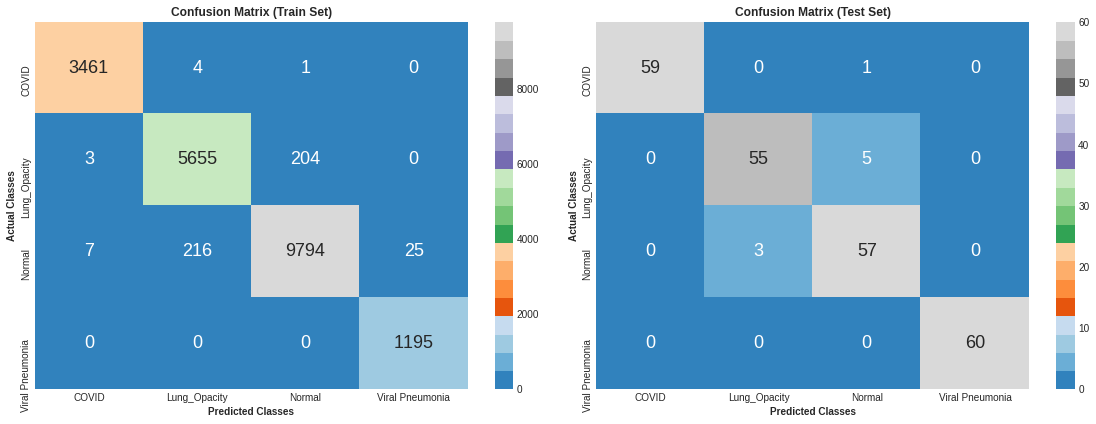

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, f'{type(resnet18).__name__.lower()}')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

{'COVID': [0.9956896551724138, 1.0, 0.9833333333333333, 0.9915966386554621],
 'Lung_Opacity': [0.9665271966527197,
  0.9482758620689655,
  0.9166666666666666,
  0.9322033898305084],
 'Normal': [0.9625, 0.9047619047619048, 0.95, 0.9268292682926829],
 'Viral Pneumonia': [1.0, 1.0, 1.0, 1.0]}

**Resnet18 with learning rate scheduler**

In [ ]:
resnet18 = get_resnet18(out_features=4, path='/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/resnet18_lr scheduler_3147_0.1/misra_resnet_cuda_18.pth')
train_preds = get_all_preds(resnet18, train_dl)
test_preds = get_all_preds(resnet18, test_dl)

train_preds.shape, test_preds.shape

(torch.Size([20565, 4]), torch.Size([240, 4]))

In [ ]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 20248	Train Accuracy: 98.46%
Test Correct:    233	Test Accuracy:  97.08%


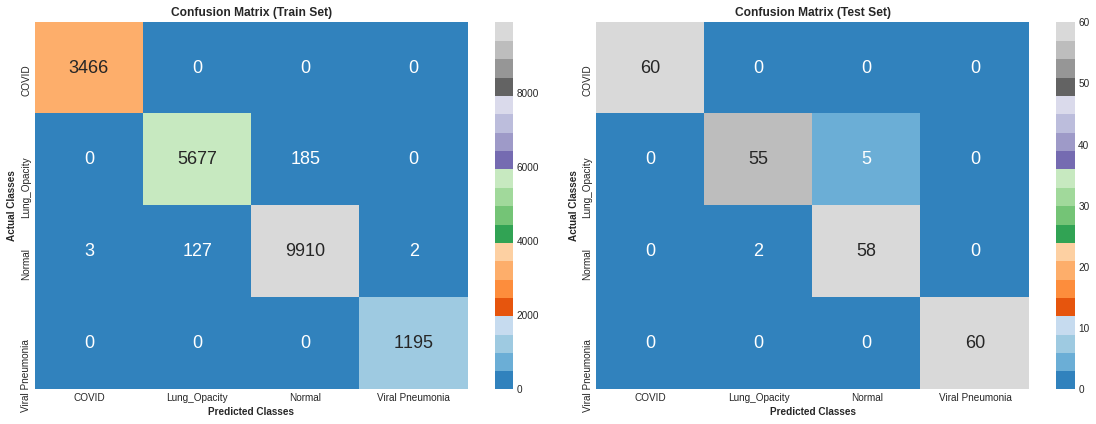

In [ ]:
train_confmat = get_confmat(train_set.targets, train_preds)
test_confmat = get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, f'{type(resnet18).__name__.lower()}')

In [ ]:
results = get_results(test_confmat, test_set.classes)
results

{'COVID': [1.0, 1.0, 1.0, 1.0],
 'Lung_Opacity': [0.9708333333333333,
  0.9649122807017544,
  0.9166666666666666,
  0.9401709401709402],
 'Normal': [0.9708333333333333,
  0.9206349206349206,
  0.9666666666666667,
  0.943089430894309],
 'Viral Pneumonia': [1.0, 1.0, 1.0, 1.0]}

**Densenet121**

In [ ]:
densenet121 = get_densenet121(out_features=4, path='/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Densenet121/misra_densenet_cuda_5.pth')
train_preds2 = get_all_preds(densenet121, train_dl)
test_preds2 = get_all_preds(densenet121, test_dl)

train_preds2.shape, test_preds2.shape

(torch.Size([20565, 4]), torch.Size([240, 4]))

In [ ]:
train_correct2 = get_num_correct(train_preds2, torch.as_tensor(train_set.targets, device=device))
test_correct2 = get_num_correct(test_preds2, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct2:5}\tTrain Accuracy: {(100*train_correct2/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct2:6}\tTest Accuracy: {(100*test_correct2/len(test_set)):6.2f}%')

Train Correct: 20000	Train Accuracy: 97.25%
Test Correct:    234	Test Accuracy:  97.50%


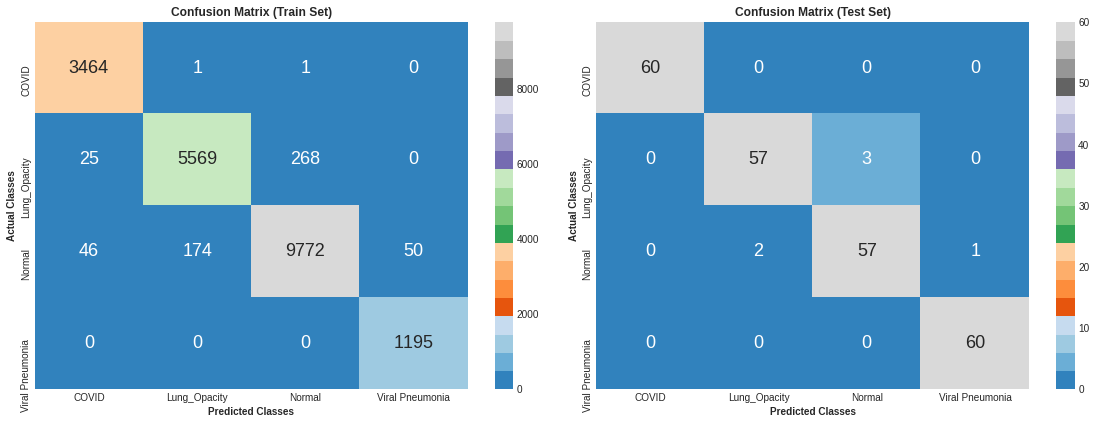

In [ ]:
train_confmat2 = get_confmat(train_set.targets, train_preds2)
test_confmat2 = get_confmat(test_set.targets, test_preds2)
plot_confmat(train_confmat2, test_confmat2, train_set.classes, f'{type(densenet121).__name__.lower()}')

In [ ]:
results = get_results(test_confmat2, test_set.classes)
results

{'COVID': [1.0, 1.0, 1.0, 1.0],
 'Lung_Opacity': [0.9790794979079498,
  0.9661016949152542,
  0.95,
  0.957983193277311],
 'Normal': [0.975, 0.95, 0.95, 0.9500000000000001],
 'Viral Pneumonia': [0.9957446808510638,
  0.9836065573770492,
  1.0,
  0.9917355371900827]}

**Densenet121 with learning rate scheduler**

In [ ]:
densenet121 = get_densenet121(out_features=4, path='/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/densenet_lr scheduler_3147_0.1/misra_densenet_cuda_12.pth')
train_preds2 = get_all_preds(densenet121, train_dl)
test_preds2 = get_all_preds(densenet121, test_dl)

train_preds2.shape, test_preds2.shape

(torch.Size([20565, 4]), torch.Size([240, 4]))

In [ ]:
train_correct2 = get_num_correct(train_preds2, torch.as_tensor(train_set.targets, device=device))
test_correct2 = get_num_correct(test_preds2, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct2:5}\tTrain Accuracy: {(100*train_correct2/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct2:6}\tTest Accuracy: {(100*test_correct2/len(test_set)):6.2f}%')

Train Correct: 20298	Train Accuracy: 98.70%
Test Correct:    235	Test Accuracy:  97.92%


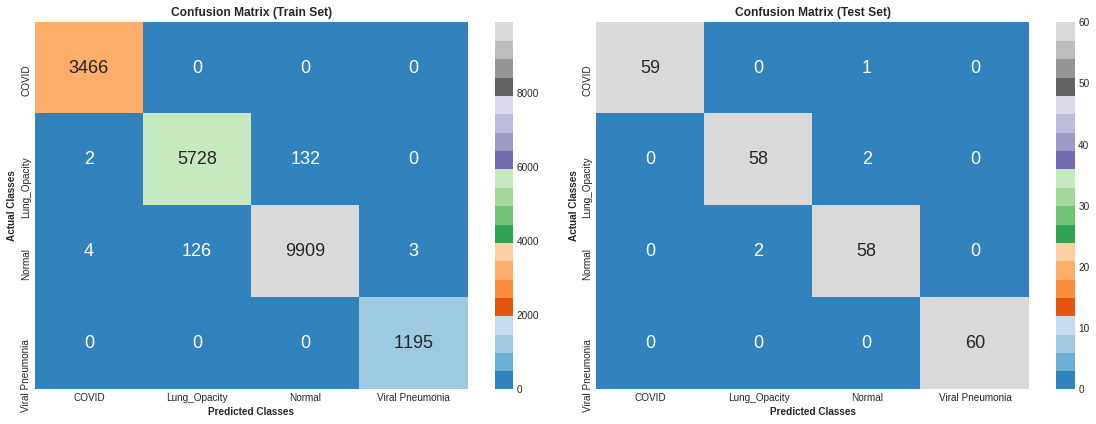

In [ ]:
train_confmat2 = get_confmat(train_set.targets, train_preds2)
test_confmat2 = get_confmat(test_set.targets, test_preds2)
plot_confmat(train_confmat2, test_confmat2, train_set.classes, f'{type(densenet121).__name__.lower()}')

In [ ]:
results = get_results(test_confmat2, test_set.classes)
results

{'COVID': [0.9957627118644068, 1.0, 0.9833333333333333, 0.9915966386554621],
 'Lung_Opacity': [0.9832635983263598,
  0.9666666666666667,
  0.9666666666666667,
  0.9666666666666667],
 'Normal': [0.9791666666666666,
  0.9508196721311475,
  0.9666666666666667,
  0.9586776859504132],
 'Viral Pneumonia': [1.0, 1.0, 1.0, 1.0]}

**Squeezenet 1.1**

In [ ]:
squeezenet1_1= get_squeezenet(out_features=4, path='/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Squeezenet1_1/misra_squeezenet_cuda_11.pth')
train_preds3 = get_all_preds(squeezenet1_1,train_dl)
test_preds3 = get_all_preds(squeezenet1_1, test_dl)

train_preds3.shape, test_preds3.shape


(torch.Size([20565, 4]), torch.Size([240, 4]))

In [ ]:
train_correct3 = get_num_correct(train_preds3, torch.as_tensor(train_set.targets, device=device))
test_correct3 = get_num_correct(test_preds3, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct3:5}\tTrain Accuracy: {(100*train_correct3/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct3:6}\tTest Accuracy: {(100*test_correct3/len(test_set)):6.2f}%')

Train Correct: 19690	Train Accuracy: 95.75%
Test Correct:    231	Test Accuracy:  96.25%


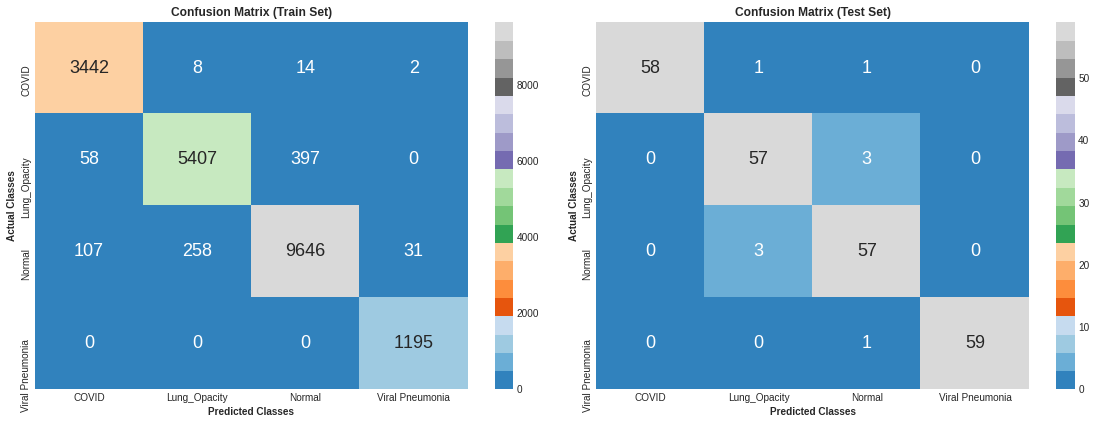

In [ ]:
train_confmat3 = get_confmat(train_set.targets, train_preds3)
test_confmat3 = get_confmat(test_set.targets, test_preds3)
plot_confmat(train_confmat3, test_confmat3, train_set.classes, f'{type(squeezenet1_1).__name__.lower()}')

In [ ]:
results = get_results(test_confmat3, test_set.classes)
results

{'COVID': [0.9914163090128756, 1.0, 0.9666666666666667, 0.983050847457627],
 'Lung_Opacity': [0.9705882352941176,
  0.9344262295081968,
  0.95,
  0.9421487603305784],
 'Normal': [0.9665271966527197, 0.9193548387096774, 0.95, 0.9344262295081968],
 'Viral Pneumonia': [0.9956896551724138,
  1.0,
  0.9833333333333333,
  0.9915966386554621]}

**Resnet50**

In [ ]:
resnet50 = get_resnet50(out_features=4, path='/content/drive/MyDrive/DL Assignment 2/COVID-19_Radiography_Dataset/Resnet50/misra_resnet_cuda_10.pth')
train_preds4 = get_all_preds(resnet50 ,train_dl)
test_preds4 = get_all_preds(resnet50 , test_dl)

train_preds4.shape, test_preds4.shape

(torch.Size([20565, 4]), torch.Size([240, 4]))

In [ ]:
train_correct4 = get_num_correct(train_preds4, torch.as_tensor(train_set.targets, device=device))
test_correct4 = get_num_correct(test_preds4, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct4:5}\tTrain Accuracy: {(100*train_correct4/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct4:6}\tTest Accuracy: {(100*test_correct4/len(test_set)):6.2f}%')

Train Correct: 20273	Train Accuracy: 98.58%
Test Correct:    230	Test Accuracy:  95.83%


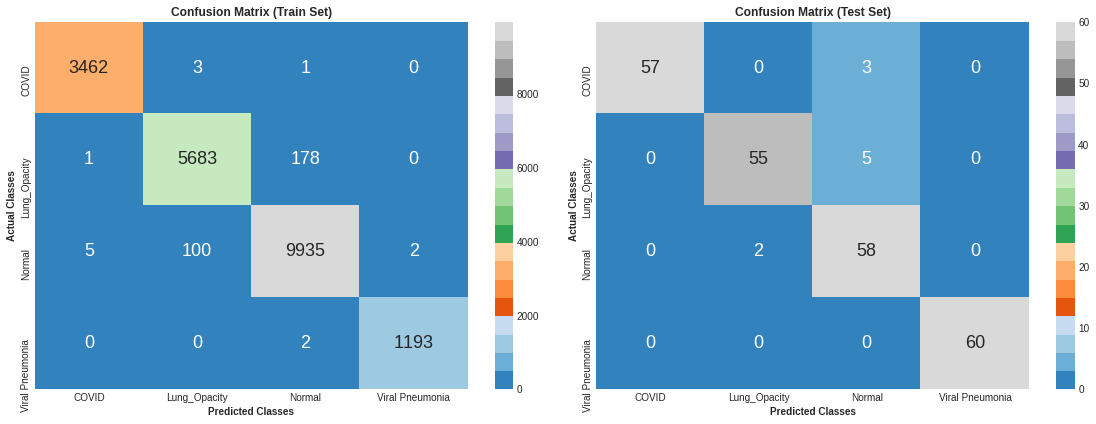

In [ ]:
train_confmat4 = get_confmat(train_set.targets, train_preds4)
test_confmat4 = get_confmat(test_set.targets, test_preds4)
plot_confmat(train_confmat4, test_confmat4, train_set.classes, f'{type(resnet50 ).__name__.lower()}')

In [ ]:
results = get_results(test_confmat4, test_set.classes)
results

{'COVID': [0.9871244635193133, 1.0, 0.95, 0.9743589743589743],
 'Lung_Opacity': [0.9704641350210971,
  0.9649122807017544,
  0.9166666666666666,
  0.9401709401709402],
 'Normal': [0.9583333333333334,
  0.8787878787878788,
  0.9666666666666667,
  0.9206349206349207],
 'Viral Pneumonia': [1.0, 1.0, 1.0, 1.0]}

# Localization with Gradient-based Class Activation Maps
To increase model interpretability, gradient-based class activation map was plotted. As per the images above, we are able to understand where the models are "looking" at in the input image.

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.featuremaps = []
        self.gradients = []

        target_layer.register_forward_hook(self.save_featuremaps)
        target_layer.register_backward_hook(self.save_gradients)

    def save_featuremaps(self, module, input, output):
        self.featuremaps.append(output)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    def get_cam_weights(self, grads):
        return np.mean(grads, axis=(1, 2))

    def __call__(self, image, label=None):
        preds = self.model(image)
        self.model.zero_grad()

        if label is None:
            label = preds.argmax(dim=1).item()

        preds[:, label].backward()

        featuremaps = self.featuremaps[-1].cpu().data.numpy()[0, :]
        gradients = self.gradients[-1].cpu().data.numpy()[0, :]

        weights = self.get_cam_weights(gradients)
        cam = np.zeros(featuremaps.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * featuremaps[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, image.shape[-2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return label, cam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


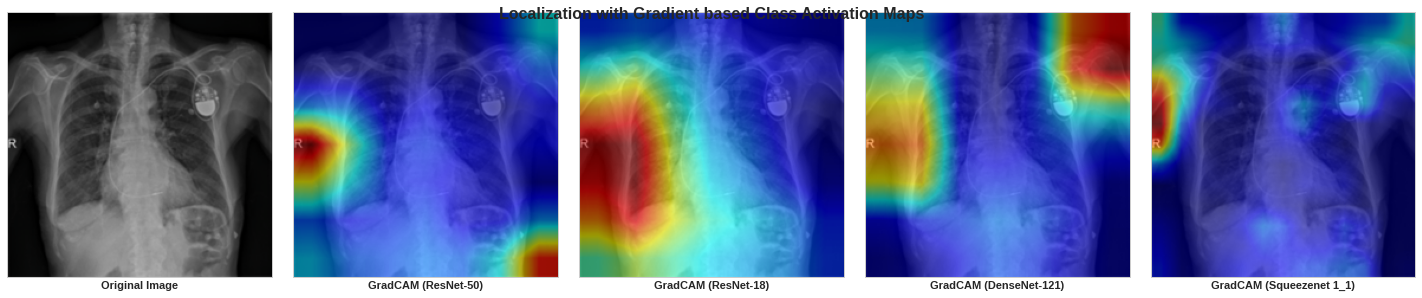

In [ ]:
image, label = test_set[50]
image = image.unsqueeze(dim=0).to(device)

cam_obj = GradCAM(model=resnet50, target_layer=resnet50.layer4[-1])
_, res50_cam = cam_obj(image, label)

cam_obj = GradCAM(model=resnet18, target_layer=resnet18.layer4[-1])
_, res18_cam = cam_obj(image, label)

cam_obj = GradCAM(model=densenet121, target_layer=densenet121.features[-1])
_, dense_cam = cam_obj(image, label)

cam_obj = GradCAM(model=squeezenet1_1, target_layer=squeezenet1_1.features[-1])
_, squeeze_cam = cam_obj(image, label)

plot_gradcam(image,res50_cam , res18_cam, dense_cam,squeeze_cam)

# References
1. The idea to compare between these 4 models was gathered from: https://www.sciencedirect.com/science/article/abs/pii/S1361841520301584

  Minaee, S., Kafieh, R., Sonka, M., Yazdani, S. and Jamalipour Soufi, G. (2020). Deep-COVID: Predicting COVID-19 from chest X-ray images using deep transfer learning. Medical Image Analysis. 65.

2. For fine-tuning Squeezenet 1.1 and Resnet50, https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html was referred.

  Inkawhich, N. (n.d.). Finetuning Torchvision Models. [Online]. Available from: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html.

3. The project above is based on: https://github.com/priyavrat-misra/xrays-and-gradcam. Additional models Squeezenet 1.1 and Resnet50 were implemented with different parameter settings.

  Priyavrat, M. (2021). Classification and Gradient-based Localization of Chest Radiographs. [Online]. 2021. github. Available from: https://github.com/priyavrat-misra/xrays-and-gradcam.
